# データとタスク #

データ：悪意のあるパケット群
タスク：それらの攻撃手法を分類する。５種類の攻撃タイプ (attack id)があり、それらは数字にエンコードされている。
特徴量：送信元と宛先IPアドレス、パケットサイズ、プロトコル、Eメール、その他のパケット情報

# 戦略 #

EDAと特徴量生成のワークフロー:

ドメイン知識を得る <br>
↓ <br>
仮説を作る <br>
↓ <br>
検証する (EDA) <br>
↓ <br>
特徴量を生成する <br>
 <br>

## ライブラリ読み込み ##

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt 

import feather
import sys
import warnings
warnings.filterwarnings("ignore")

import gc


## データタイプの置き換えとfeather fileへ変更することでメモリを削減 ##

In [14]:
# Reference: https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65

# def reduce_mem_usage(df, verbose=True):
#     numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]
#     start_mem = df.memory_usage().sum() / 1024 ** 2
#     for col in df.columns:
#         col_type = df[col].dtypes
#         if col_type in numerics:
#             c_min = df[col].min()
#             c_max = df[col].max()
#             if str(col_type)[:3] == "int":
#                 if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
#                     df[col] = df[col].astype(np.int8)
#                 elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
#                     df[col] = df[col].astype(np.int16)
#                 elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
#                     df[col] = df[col].astype(np.int32)
#                 elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
#                     df[col] = df[col].astype(np.int64)
#             else:
#                 if (
#                     c_min > np.finfo(np.float16).min
#                     and c_max < np.finfo(np.float16).max
#                 ):
#                     df[col] = df[col].astype(np.float16)
#                 elif (
#                     c_min > np.finfo(np.float32).min
#                     and c_max < np.finfo(np.float32).max
#                 ):
#                     df[col] = df[col].astype(np.float32)
#                 else:
#                     df[col] = df[col].astype(np.float64)
#     end_mem = df.memory_usage().sum() / 1024 ** 2
#     if verbose:
#         print(
#             "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
#                 end_mem, 100 * (start_mem - end_mem) / start_mem
#             )
#         )
#     return df


# q1 = pd.read_csv('./q1_total.csv',encoding="ISO-8859-1")
# reduce_mem_usage(q1)
# feather.write_dataframe(q1, './q1_total.feather')


# データ読み込み #

In [15]:
q1 = feather.read_dataframe('./total_q1.feather')

q1.rename(columns={'No.':'id','Time':'time','Source':'source','Destination':'destination',
                   'Protocol':'protocol','Length':'length','Info':'info'},inplace=True)

q1.drop('packetid',axis=1,inplace=True)

print(q1.head())

res = q1[q1['info'].str.contains('response')]
sub = q1[~q1['info'].str.contains('response')]


train = sub[~sub['attackid'].isnull()]
test = sub[sub['attackid'].isnull()]

   id      time          source    destination protocol  length  \
0   1  0.000000   214.13.212.97    45.80.170.1      DNS      88   
1   2  0.000255     45.80.170.1  214.13.212.97      DNS     432   
2   3  0.001941   255.176.91.32    45.80.170.1      DNS      89   
3   4  0.002090     45.80.170.1  255.176.91.32      DNS     396   
4   5  0.011864  214.180.95.136    45.80.170.1      DNS      87   

                                                info  attackid  
0      Standard query 0x437f A www.94e207.com.cn OPT       NaN  
1  Standard query response 0x437f A www.94e207.co...       NaN  
2  Standard query 0x87a8 AAAA dns.32477b4.com.cn OPT       NaN  
3  Standard query response 0x87a8 AAAA dns.32477b...       NaN  
4    Standard query 0x1658 AAAA dns2.f0a1.com.cn OPT       NaN  


# EDAと特徴量生成 #

## 欠損値 ##

In [16]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

print('Missing data for training data: \n',missing_data)
print()

total = test.drop('attackid',axis=1).isnull().sum().sort_values(ascending=False)
percent = (test.drop('attackid',axis=1).isnull().sum()/test.drop('attackid',axis=1).isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

print('Missing data for test data: \n ',missing_data)


Missing data for training data: 
              Total  Percent
attackid         0      0.0
info             0      0.0
length           0      0.0
protocol         0      0.0
destination      0      0.0
source           0      0.0
time             0      0.0
id               0      0.0

Missing data for test data: 
               Total  Percent
info             0      0.0
length           0      0.0
protocol         0      0.0
destination      0      0.0
source           0      0.0
time             0      0.0
id               0      0.0


結果：欠損値なし

## 一つの宛先ipアドレスの攻撃手法数 ##

ドメイン知識:  <br> 攻撃者は同じipアドレスを使って２つの異なった攻撃手法を使わない <br>
仮定:  <br> ipアドレスと攻撃手法が分かれば、同じipアドレスを持っている全ての他パケットの攻撃手法もわかる

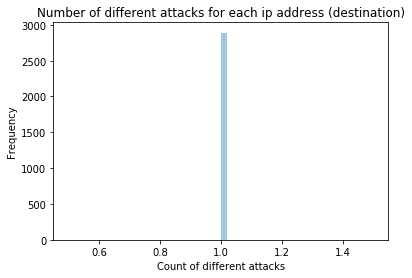

7591

In [17]:
dest = sub.dropna().groupby(['destination','attackid'],as_index=False)['id'].count()
sns.distplot(dest.groupby(['destination'],as_index=False)['attackid'].count()['attackid'].values,kde=False)

plt.title('Number of different attacks for each ip address (destination)')

plt.xlabel("Count of different attacks")
plt.ylabel("Frequency")

plt.savefig('./figure/count_dif_attacks')
plt.show()

del dest; gc.collect()

結果: <br> 真。 訓練データ内のそれぞれのipアドレスは一つの手法しか使っていない。よってテストデータでも一つのipアドレスから攻撃手法がわかれば、他の同じipアドレスを用いたパケットの攻撃手法もわかる確率が高い。

## 一つの送信元ipアドレスの攻撃手法数 ##

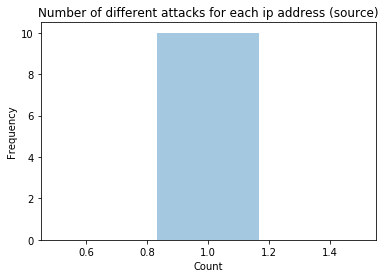

2148

In [18]:
source = sub.dropna().groupby(['source','attackid'],as_index=False)['id'].count()
sns.distplot(source.groupby(['source'],as_index=False)['attackid'].count()['attackid'].values,kde=False)

plt.xlabel("Count")
plt.ylabel("Frequency")

plt.title('Number of different attacks for each ip address (source)')

plt.xlabel("Count")
plt.ylabel("Frequency")

plt.show()

del source; gc.collect()

## 訓練データとテストデータで共通の宛先IPアドレスまたは送信元IPアドレスの比率 ##

仮説：訓練データとテストデータには共通のIPアドレスを持ったパケットが存在する

In [19]:
num = train[train['destination'].isin(test['destination'].values) | train['source'].isin(test['source'].values)].shape[0]

print(num/train.shape[0]*100,'%')

52.06997159492565 %


結果：訓練データはテストデータのIPアドレスの約半分をカバーしている。よって訓練データを使えば、テストデータ内のパケットの攻撃手法をほぼ確実に約50％分かる。

結果は宛先ipアドレスと同様である。

# 攻撃手法の分布 #

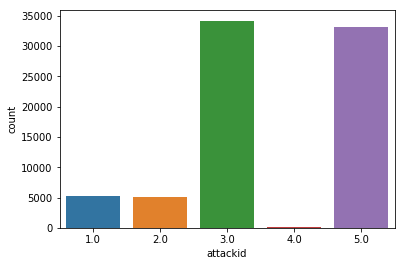

In [20]:
ax = sns.countplot(x="attackid", data=sub)

plt.savefig('./figure/target_distribution')

結果: 攻撃手法は一様分布ではない。よって交差検証の手法を気を付ける必要がある。

## 送信パケットサイズの確率密度関数 ##

ドメイン知識: DoS攻撃のような沢山のパケットを使ってサーバーをダウンさせる手法では、それを可能にするためパケットサイズを小さくする必要がある。 <br>
 <br>
仮説:  攻撃手法はパケットサイズによる。

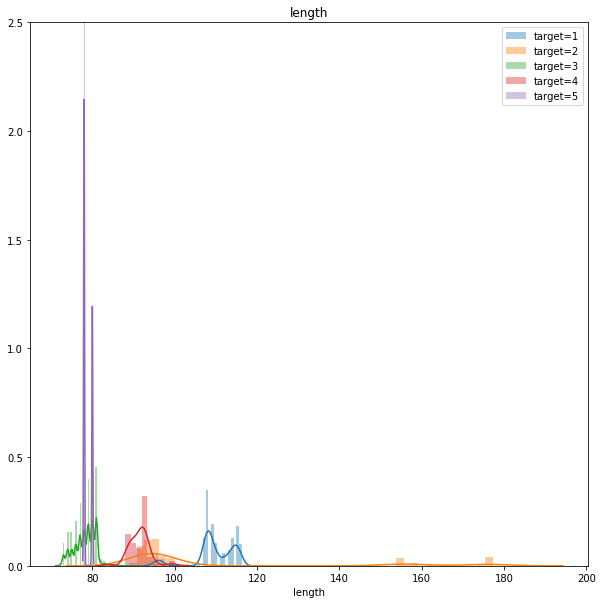

In [21]:
numerical = ['length']

attackids = [1,2,3,4,5]

for feature in numerical:
	fig, ax = plt.subplots(figsize=(10,10))
	plt.title(feature)
	
	for i in attackids:
		ax = sns.distplot(sub[sub['attackid']==i][feature],label='target=' + str(i))

	plt.legend() # Plot label in the graph
	plt.ylim(0,2.5)
	plt.savefig('./figure/size_packets.png')
	plt.show()


結果は真。 <br>
Attack id 5 は小さなパケットサイズを頻繁に使っているのに対し他のattackid（攻撃手法）のパケットサイズの範囲は比較的広い。また攻撃手法によって、パケットサイズのはっきりとした境界線が引かれているように見える。
 <br>

## パケットの頻度 ##

ドメイン知識: DoS 攻撃のような手法では多くのパケットを使う. <br>
 <br>
仮説: 攻撃手法は送信されたパケット数による。

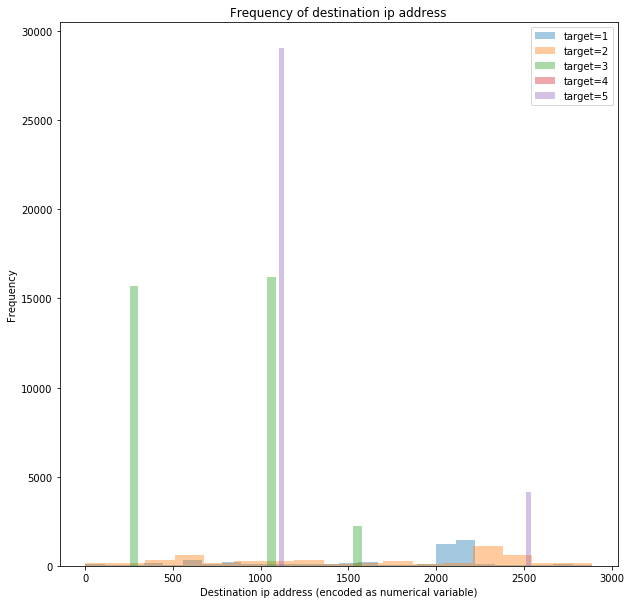

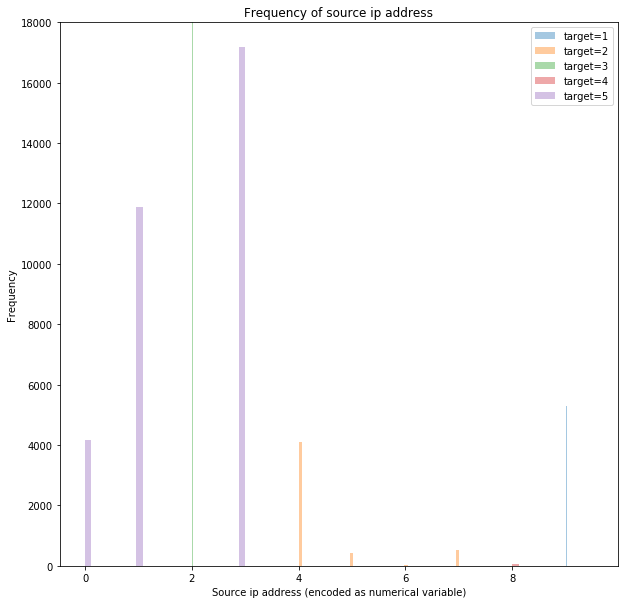

In [22]:
numerical = ['destination','source']

attackids = [1,2,3,4,5]

label_cols = ['source', 'destination']

# Label Encoding
from sklearn.preprocessing import LabelEncoder

for col in label_cols:
    if col in train.columns:
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))

for feature in numerical:
	fig, ax = plt.subplots(figsize=(10,10))
	plt.title(feature)
	
	for i in attackids:
		ax = sns.distplot(train[train['attackid']==i][feature],label='target=' + str(i),kde=False)

	if feature == 'destination':
		plt.title('Frequency of destination ip address')
		plt.xlabel("Destination ip address (encoded as numerical variable)")
		plt.ylabel("Frequency")
# 		plt.ylim(0,5000)
	else:
		plt.title('Frequency of source ip address')
		plt.xlabel("Source ip address (encoded as numerical variable)")
		plt.ylabel("Frequency")
		plt.ylim(0,18000)

	plt.legend() # Plot label in the graph
	plt.savefig('./figure/'+ str(feature) + '.png')
	plt.show()

結果: いくつかの攻撃手法では使うパケット数に確かなトレンドがある。例えば攻撃手法２と５は多くのパケットを使っている.

## Eメール ##

ドメイン知識: ドメイン偽装のような自身のドメインを他のサイトのドメインに成りすますような手法がある。 <br>
 <br>
仮説:  攻撃手法はEメールのドメインに左右される。

In [23]:
temp = sub['info'].str.split(expand=True)
temp.columns = ['info_' + str(i) for i in temp.columns.values]

temp = temp[:1000]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     I just display first 5 rows of data for submission
    print(temp.groupby('info_4',as_index=False)['info_1'].count().head(5))


        info_4  info_1
0  0798.com.cn       2
1   0f3.com.cn       1
2  10d5.com.cn       2
3  1988.com.cn       2
4  1c8c.com.cn       1


結果: 偽。".co0m.cn."のドメインしかなく、メール自体もあまり意味を成さない作られたものが多い。

（このノートでは最初の５行しか出力していない）

# モデル #

## LightGBM ##

交差検証にはStratified K-foldを使う

IPアドレスは種類が多すぎるためOne hotではなく数値にエンコードする。

train_X:  (77803, 5)
train_y:  (77803,)

 fold 0
train_idx:  62241
val_idx:  15562

 ip address Overlap 65.72677174209926 % 

Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[180]	training's multi_logloss: 2.79093e-08	valid_1's multi_logloss: 3.49986e-08

 fold 1
train_idx:  62241
val_idx:  15562

 ip address Overlap 91.78355103549107 % 

Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[249]	training's multi_logloss: 2.91695e-08	valid_1's multi_logloss: 2.9278e-08

 fold 2
train_idx:  62243
val_idx:  15560

 ip address Overlap 91.78381504747522 % 

Training until validation scores don't improve for 500 rounds.
[1000]	training's multi_logloss: 2.52175e-08	valid_1's multi_logloss: 0.00453654
[2000]	training's multi_logloss: 2.51585e-08	valid_1's multi_logloss: 0.00453654
[3000]	training's multi_logloss: 2.51292e-08	valid_1's multi_logloss: 0.00453654
[4000]	training's multi_logloss: 2.5111

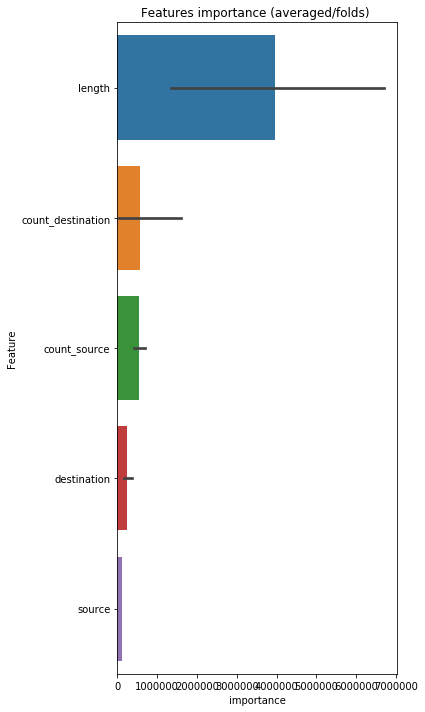

In [24]:
import lightgbm as lgb
from scipy import stats
from tqdm import tqdm_notebook
from sklearn.model_selection import StratifiedKFold
from statistics import mean
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Fix seeds
from numpy.random import seed
seed(0)

np.set_printoptions(suppress=True)


# Load data
q1 = feather.read_dataframe('./total_q1.feather')

q1.rename(columns={'No.':'id','Time':'time','Source':'source','Destination':'destination',
                   'Protocol':'protocol','Length':'length','Info':'info'},inplace=True)

q1 = q1[~q1['info'].str.contains('response')]


train = q1[~q1['attackid'].isnull()]
test = q1[q1['attackid'].isnull()]


# Count encoding
count_features = ['source','destination']

for feature in count_features:
	train['count_' + feature] = train[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))
	test['count_' + feature] = test[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))


train.drop(['time','info','protocol'],axis=1,inplace=True)
test.drop(['time','info','protocol'],axis=1,inplace=True)


label_cols = ['source', 'destination']

# Label Encoding
from sklearn.preprocessing import LabelEncoder

for col in label_cols:
    if col in train.columns:
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))

        
train_y = train['attackid']
train_X = train.drop(['attackid','packetid','id'], axis=1)

test_packetid = test['id']

test_X = test.drop(['attackid','packetid','id'], axis=1)

metric = 'multi_logloss'

params = {
		  'objective': 'multiclass',
		  "metric": metric,
		 }


folds = StratifiedKFold(n_splits=5)

# Out of fold predictions
oof = np.zeros(shape=(len(train_X),5))

# Predictions for test data
predictions = np.zeros(shape=(len(test_X),5))
feature_importance_df = pd.DataFrame()

print('train_X: ',train_X.shape)
print('train_y: ',train_y.shape)

loss = list()

#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_X,train_y)):
	strLog = "\n fold {}".format(fold_)
	print(strLog)

# 	Output the size of train and validation index
	print('train_idx: ',len(trn_idx))
	print('val_idx: ',len(val_idx))

	X_tr, X_val = train_X.iloc[trn_idx], train_X.iloc[val_idx]
	y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]


	# Check the percentage of ip address overlaps between training data and validation data
	num = X_tr[X_tr['destination'].isin(X_val['destination'].values) | X_tr['source'].isin(X_val['source'].values)].shape[0]
	print("\n ip address Overlap",num/X_tr.shape[0]*100,'% \n')
    
	model = lgb.LGBMClassifier(**params, n_estimators=5000, importance_type='gain', n_jobs=-1)

	model.fit(X_tr,
			  y_tr,
			  eval_set=[(X_tr,y_tr),(X_val, y_val)],
			  verbose=1000,
			  early_stopping_rounds=500)

	# Out of fold predictions
	oof[val_idx] = model.predict_proba(X_val, num_iteration=model.best_iteration_)

	# Test prediction
	predictions += (model.predict_proba(test_X, num_iteration=model.best_iteration_)) / folds.n_splits

	loss.append(model.best_score_['valid_1'][metric])

	#Feature importance
	fold_importance_df = pd.DataFrame()
	fold_importance_df["Feature"] = train_X.columns.values
	fold_importance_df["importance"] = model.feature_importances_[:len(train_X.columns.values)]
	fold_importance_df["fold"] = fold_ + 1
	feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

print('Mean log loss = ',mean(loss))

oof = (np.argmax(oof,axis=1)+1).astype(int)

print()
print('Mean accuracy score = {}'.format(accuracy_score(train_y.values, oof)))


print('[' + str(len(train_X.columns.values))+']')
print(train_X.columns.values)

cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False).index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(6,10))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds) ')
plt.tight_layout()

plt.savefig('./figure/importance.png')
plt.show()


# Make submission file
test_X['attackid'] = (np.argmax(predictions,axis=1)+1).astype(int)
test_X['packetid'] = test_packetid

test_X[['packetid','attackid']].to_csv('./traffic.csv',header=True,index=False)



結果：訓練データにIPアドレスが含まれていなくとも高い精度を発揮できるモデルを生成出来た。